In [1]:
import pandas as pd
data = pd.read_csv('family_data.csv', index_col='family_id')
FAMILY_SIZE = data.n_people.values
DESIRED     = data.values[:, :-1] - 1

In [2]:
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125
NUMBER_DAYS = 100
NUMBER_FAMILIES = 5000

import numpy as np

def GetPreferenceMatrix(data):
    pref_matrix = np.zeros((NUMBER_FAMILIES, NUMBER_DAYS), dtype=np.int64)
    for i in range(NUMBER_FAMILIES):
        desired = data.values[i, :-1]
        pref_matrix[i, :] = 10
        for j, day in enumerate(desired):
            pref_matrix[i, day-1] = j
    return pref_matrix

PREFERENCE_MATRIX = GetPreferenceMatrix(data)

In [3]:
def get_penalty(n, choice):
    penalty = None
    if choice == 0:
        penalty = 0
    elif choice == 1:
        penalty = 50
    elif choice == 2:
        penalty = 50 + 9 * n
    elif choice == 3:
        penalty = 100 + 9 * n
    elif choice == 4:
        penalty = 200 + 9 * n
    elif choice == 5:
        penalty = 200 + 18 * n
    elif choice == 6:
        penalty = 300 + 18 * n
    elif choice == 7:
        penalty = 300 + 36 * n
    elif choice == 8:
        penalty = 400 + 36 * n
    elif choice == 9:
        penalty = 500 + 36 * n + 199 * n
    else:
        penalty = 500 + 36 * n + 398 * n
    return penalty

In [4]:
def GetAssignmentCostMatrix(data):
    cost_matrix = np.zeros((NUMBER_FAMILIES, NUMBER_DAYS), dtype=np.int64)
    for i in range(NUMBER_FAMILIES):
        desired = data.values[i, :-1]
        cost_matrix[i, :] = get_penalty(FAMILY_SIZE[i], 10)
        for j, day in enumerate(desired):
            cost_matrix[i, day-1] = get_penalty(FAMILY_SIZE[i], j)
    return cost_matrix
ASSIGNMENT_COST_MATRIX = GetAssignmentCostMatrix(data)
ASSIGNMENT_COST_MATRIX

array([[2236, 2236, 2236, ..., 2236, 2236, 2236],
       [2236, 2236, 2236, ..., 2236, 2236, 2236],
       [1802, 1802, 1802, ..., 1802, 1802,    0],
       ...,
       [3104, 3104,  616, ..., 3104, 3104, 3104],
       [ 390, 2670, 2670, ..., 2670, 2670, 2670],
       [2236, 2236, 2236, ..., 2236, 2236, 2236]])

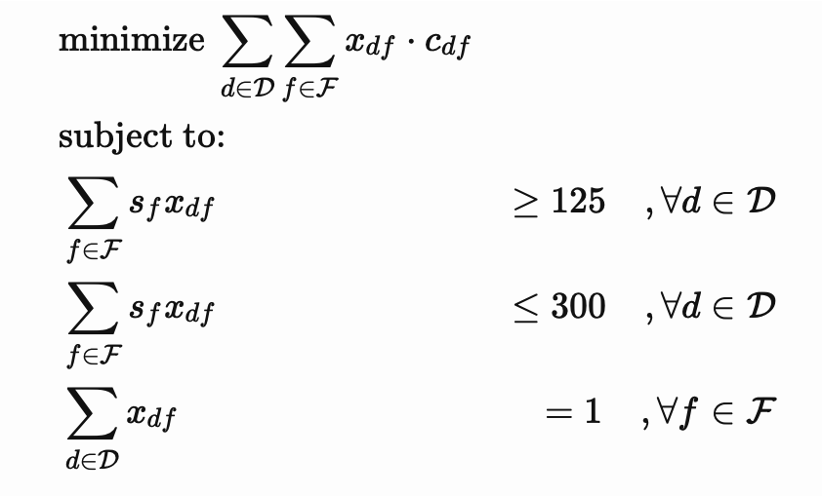

In [5]:
import pulp as pl
MAX_PREF_ALLOWED = 3
x = {}
C = {}
key = {} # key[i, j] is the index od variable that corresponds to the edge (i, j)
K = 0
cost = []

for i in range(NUMBER_FAMILIES):
    for j in range(NUMBER_DAYS):
        if PREFERENCE_MATRIX[i, j] <= MAX_PREF_ALLOWED:
            key[i, j] = K
            x[K] = pl.LpVariable('x[%i,%i]' % (i, j), 0, 1, pl.LpInteger)
            C[K] = ASSIGNMENT_COST_MATRIX[i, j]
            cost.append(C[K]*x[K])
            K = K + 1
        else:
            key[i, j] = -1

In [6]:
# define the problem
prob = pl.LpProblem("SantaWorkshop", pl.LpMinimize)

In [7]:
# objective function
prob += pl.lpSum(cost)

In [8]:
# constraints
for i in range(NUMBER_FAMILIES):
    prob += pl.lpSum([x[key[i, j]] for j in range(NUMBER_DAYS) if key[i, j] >= 0 ]) == 1


for i in range(NUMBER_DAYS):
    c = pl.lpSum([(x[key[j, i]] * FAMILY_SIZE[j]) for j in range(NUMBER_FAMILIES) if key[j, i] >= 0 ])
    prob += c >= MIN_OCCUPANCY
    prob += c <= MAX_OCCUPANCY

In [9]:
status = prob.solve(pl.PULP_CBC_CMD(timeLimit=7200, gapRel=0.01))
print("Result:", pl.LpStatus[status])

Result: Optimal


In [10]:
assign = {}
for i in range(NUMBER_FAMILIES):
    for j in range(NUMBER_DAYS):
        if key[i, j] >= 0:
            if pl.value(x[key[i, j]]) > 0.99:
                assign[i] = j

In [11]:
assign

{0: 51,
 1: 25,
 2: 99,
 3: 1,
 4: 52,
 5: 31,
 6: 87,
 7: 24,
 8: 17,
 9: 87,
 10: 91,
 11: 74,
 12: 97,
 13: 53,
 14: 44,
 15: 21,
 16: 45,
 17: 46,
 18: 74,
 19: 2,
 20: 2,
 21: 55,
 22: 60,
 23: 18,
 24: 74,
 25: 15,
 26: 57,
 27: 37,
 28: 80,
 29: 88,
 30: 67,
 31: 73,
 32: 23,
 33: 31,
 34: 45,
 35: 97,
 36: 46,
 37: 14,
 38: 12,
 39: 9,
 40: 24,
 41: 91,
 42: 80,
 43: 10,
 44: 48,
 45: 4,
 46: 14,
 47: 44,
 48: 31,
 49: 32,
 50: 66,
 51: 27,
 52: 32,
 53: 36,
 54: 68,
 55: 90,
 56: 11,
 57: 30,
 58: 73,
 59: 38,
 60: 97,
 61: 17,
 62: 38,
 63: 62,
 64: 2,
 65: 46,
 66: 81,
 67: 93,
 68: 84,
 69: 4,
 70: 31,
 71: 70,
 72: 65,
 73: 9,
 74: 81,
 75: 52,
 76: 78,
 77: 19,
 78: 51,
 79: 36,
 80: 17,
 81: 16,
 82: 31,
 83: 87,
 84: 8,
 85: 53,
 86: 28,
 87: 24,
 88: 56,
 89: 22,
 90: 53,
 91: 16,
 92: 84,
 93: 4,
 94: 46,
 95: 23,
 96: 74,
 97: 95,
 98: 2,
 99: 38,
 100: 38,
 101: 52,
 102: 28,
 103: 67,
 104: 46,
 105: 11,
 106: 33,
 107: 11,
 108: 33,
 109: 16,
 110: 66,
 111: 67,
 

In [12]:
def cost_function(prediction):

    penalty = 0
    days = range(0, NUMBER_DAYS)

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = data.n_people[f]
        choice_0 = data['choice_0'][f]-1
        choice_1 = data['choice_1'][f]-1
        choice_2 = data['choice_2'][f]-1
        choice_3 = data['choice_3'][f]-1
        choice_4 = data['choice_4'][f]-1
        choice_5 = data['choice_5'][f]-1
        choice_6 = data['choice_6'][f]-1
        choice_7 = data['choice_7'][f]-1
        choice_8 = data['choice_8'][f]-1
        choice_9 = data['choice_9'][f]-1

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

In [13]:
penalty = cost_function(assign.values())

In [14]:
penalty

13403337617.161863

* Objective value:                43841.00000000
* Lower bound:                    43608.189
* Gap:                            0.01
* Enumerated nodes:               4
* Total iterations:               2011
* Time (CPU seconds):             8.82
* Time (Wallclock seconds):       9.43

In [15]:
print(prob.objective.value())

43841.0


# With accounting costs

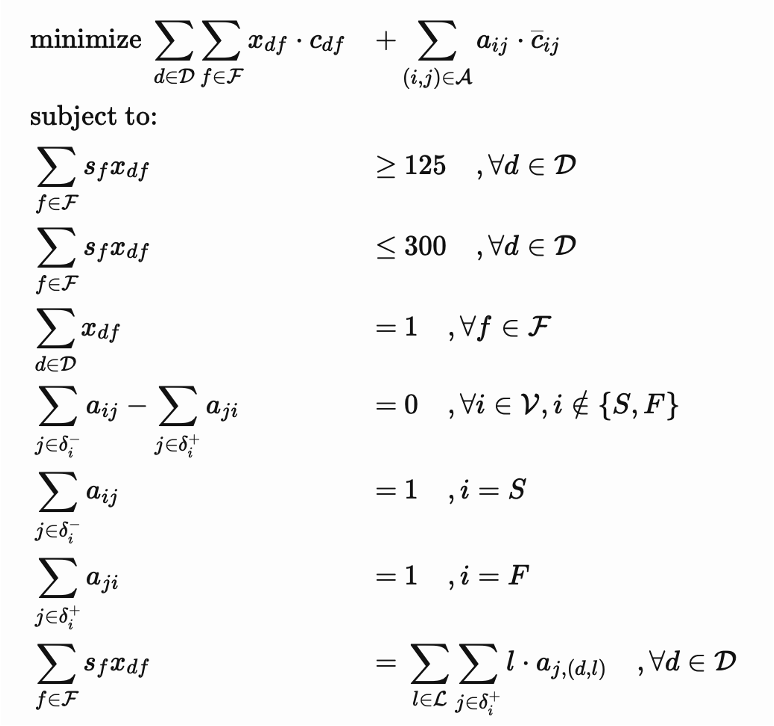

In [16]:
# define the problem
import pulp as pl
prob_accounting = pl.LpProblem("SantaWorkshopAccounting", pl.LpMinimize)

In [17]:
MAX_PREF_ALLOWED = 3
x = {}
C = {}
key = {} # key[i, j] is the index od variable that corresponds to the edge (i, j)
K = 0
cost = []

for i in range(NUMBER_FAMILIES):
    for j in range(NUMBER_DAYS):
        if PREFERENCE_MATRIX[i, j] <= MAX_PREF_ALLOWED:
            key[i, j] = K
            x[K] = pl.LpVariable('x[%i,%i]' % (i, j), 0, 1, pl.LpInteger)
            C[K] = ASSIGNMENT_COST_MATRIX[i, j]
            cost.append(C[K]*x[K])
            K = K + 1
        else:
            key[i, j] = -1

In [18]:
a = np.zeros(shape = (100,301,301))
y = {}
accounting_costs = []
for d in range(NUMBER_DAYS):
    for i in range(MIN_OCCUPANCY,MAX_OCCUPANCY+1):
        for j in range(MIN_OCCUPANCY,MAX_OCCUPANCY+1):
            a[d,i,j] = (i - 125) / 400 * i ** (0.5 + abs(i - j) / 50)       
            y[d,i,j] = pl.LpVariable('y[%d,%i,%i]' % (d, i, j), 0, 1, pl.LpInteger)
            accounting_costs.append(a[d,i,j] * y[d,i,j])

In [19]:
prob_accounting += pl.lpSum(cost) + pl.lpSum(accounting_costs)

In [20]:
# constraints
for i in range(NUMBER_FAMILIES):
    prob_accounting += pl.lpSum([x[key[i, j]] for j in range(NUMBER_DAYS) if key[i, j] >= 0 ]) == 1 # family assigned to only one day constraint


for i in range(NUMBER_DAYS):
    c = pl.lpSum([(x[key[j, i]] * FAMILY_SIZE[j]) for j in range(NUMBER_FAMILIES) if key[j, i] >= 0 ])
    prob_accounting += c >= MIN_OCCUPANCY
    prob_accounting += c <= MAX_OCCUPANCY
# visitors per day between 125 and 300
    

for d in range(1,NUMBER_DAYS-1):
    for j in range(MIN_OCCUPANCY,MAX_OCCUPANCY+1):
        expr_1 = pl.lpSum([y[d,i,j] for i in range(MIN_OCCUPANCY,MAX_OCCUPANCY+1)])
        expr_2 = pl.lpSum([y[d+1,j,k] for k in range(MIN_OCCUPANCY,MAX_OCCUPANCY+1)])
        prob_accounting += (expr_1 - expr_2) == 0
        # ensure that for y_{d,i,j} there is only one k where y_{d+1,j,k}=1 -> in graph terms ensure that we have an outgoing arc

In [21]:
for d in range(NUMBER_DAYS):
    c = pl.lpSum([(x[key[j, i]] * FAMILY_SIZE[j]) for j in range(NUMBER_FAMILIES) if key[j, i] >= 0 ])
    expr = pl.lpSum([i*y[d,i,j] for j in range(MIN_OCCUPANCY,MAX_OCCUPANCY+1) for i in range(MIN_OCCUPANCY,MAX_OCCUPANCY+1)])
    prob_accounting += c - expr == 0
# link between x and y variable -> assign i visitors on day d when there is an incoming arc

In [22]:
for d in range(NUMBER_DAYS):
    expr = pl.lpSum([y[d,i,j] for j in range(MIN_OCCUPANCY,MAX_OCCUPANCY+1) for i in range(MIN_OCCUPANCY,MAX_OCCUPANCY+1)])
    prob_accounting += expr == 1
# for each day when there is i visitors, on day d+1 there is j visitors

# y_{d,i,j} = 1 when there are i visitors on day d, and j visitors on d+1 so when we sum that across all visitors it should be 1
#otherwise it would mean that on one day there were two different numbers of visitors

In [23]:
status = prob_accounting.solve(pl.PULP_CBC_CMD(timeLimit=7200, gapRel=0.01))
print("Result:", pl.LpStatus[status])

Result: Optimal


In [24]:
assign = {}
for i in range(NUMBER_FAMILIES):
    for j in range(NUMBER_DAYS):
        if key[i, j] >= 0:
            if pl.value(x[key[i, j]]) > 0.99:
                assign[i] = j

In [25]:
penalty = cost_function(assign.values())

In [26]:
penalty

12935351254.38798

In [27]:
print(prob_accounting.objective.value())

43856.0


In [28]:
assign

{0: 51,
 1: 25,
 2: 99,
 3: 1,
 4: 52,
 5: 31,
 6: 87,
 7: 24,
 8: 17,
 9: 87,
 10: 91,
 11: 74,
 12: 97,
 13: 53,
 14: 44,
 15: 21,
 16: 45,
 17: 46,
 18: 74,
 19: 2,
 20: 2,
 21: 55,
 22: 60,
 23: 18,
 24: 74,
 25: 15,
 26: 57,
 27: 37,
 28: 80,
 29: 88,
 30: 67,
 31: 73,
 32: 23,
 33: 31,
 34: 45,
 35: 30,
 36: 46,
 37: 14,
 38: 12,
 39: 9,
 40: 24,
 41: 91,
 42: 80,
 43: 10,
 44: 48,
 45: 4,
 46: 14,
 47: 44,
 48: 31,
 49: 32,
 50: 66,
 51: 27,
 52: 32,
 53: 36,
 54: 68,
 55: 90,
 56: 11,
 57: 30,
 58: 73,
 59: 38,
 60: 97,
 61: 17,
 62: 38,
 63: 62,
 64: 2,
 65: 46,
 66: 81,
 67: 93,
 68: 84,
 69: 4,
 70: 31,
 71: 70,
 72: 65,
 73: 9,
 74: 81,
 75: 52,
 76: 78,
 77: 19,
 78: 51,
 79: 36,
 80: 17,
 81: 16,
 82: 31,
 83: 87,
 84: 8,
 85: 53,
 86: 28,
 87: 24,
 88: 56,
 89: 22,
 90: 53,
 91: 16,
 92: 84,
 93: 4,
 94: 46,
 95: 23,
 96: 74,
 97: 95,
 98: 2,
 99: 38,
 100: 38,
 101: 52,
 102: 28,
 103: 67,
 104: 46,
 105: 11,
 106: 33,
 107: 11,
 108: 33,
 109: 16,
 110: 66,
 111: 67,
 